# **ResNet 18, Regularization and Transfer Learning**

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics
from torchvision import models

class ResNet18Model(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.train_losses = []
        self.val_losses = []


        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)


        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_losses.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.val_losses.append(loss.item())
        self.log("val_loss", loss)
        self.log("val_accuracy", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
from torchvision import transforms
from torchvision.datasets import Imagenette
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint



train_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=train_transforms)


train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = test_transforms


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=8, shuffle=False)


test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=True, transform=test_transforms)

model = ResNet18Model()


early_stop_callback = EarlyStopping(monitor="val_loss",
                                    mode="min",
                                    patience=5)


checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min"
)

100%|██████████| 99.0M/99.0M [00:02<00:00, 48.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 99.0M/99.0M [00:02<00:00, 42.9MB/s]


In [ ]:
import matplotlib.pyplot as plt


def plot_losses(model):

    train_loss_per_epoch = [sum(model.train_losses[i:i+len(train_loader)]) / len(train_loader)
                            for i in range(0, len(model.train_losses), len(train_loader))]
    val_loss_per_epoch = [sum(model.val_losses[i:i+len(val_loader)]) / len(val_loader)
                          for i in range(0, len(model.val_losses), len(val_loader))]

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_per_epoch, label="Training Loss")
    plt.plot(val_loss_per_epoch, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
trainer = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
69        Modules in train mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
train_loss_per_epoch = [sum(model.train_losses[i:i+len(train_loader)]) / len(train_loader)
                        for i in range(0, len(model.train_losses), len(train_loader))]
val_loss_per_epoch = [
    sum(model.val_losses[i:i + len(val_loader)]) / len(val_loader)
    for i in range(0, len(model.val_losses), len(val_loader))
]


final_train_loss = train_loss_per_epoch[-1]
final_val_loss = val_loss_per_epoch[-1]


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=8, shuffle=False)
trainer.test(model=model, dataloaders=test_loader)
print(f" Training Loss: {final_train_loss:.4f}")
print(f" Validation Loss: {final_val_loss:.4f}")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5640764236450195     │
│         test_loss         │    1.9371172189712524     │
└───────────────────────────┴───────────────────────────┘

 Training Loss: 0.2619
 Validation Loss: 0.4594


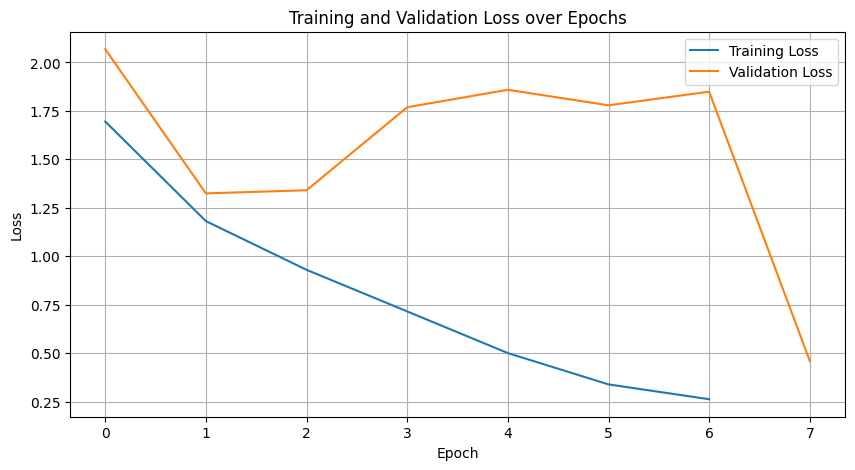

In [ ]:
import matplotlib.pyplot as plt


def plot_losses(model):

    train_loss_per_epoch = [sum(model.train_losses[i:i+len(train_loader)]) / len(train_loader)
                            for i in range(0, len(model.train_losses), len(train_loader))]
    val_loss_per_epoch = [sum(model.val_losses[i:i+len(val_loader)]) / len(val_loader)
                          for i in range(0, len(model.val_losses), len(val_loader))]

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_per_epoch, label="Training Loss")
    plt.plot(val_loss_per_epoch, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_losses(model)

# ResNet-18 Architecture

-> The input to the model is a grayscale image resized to 64×64 pixels.

-> The standard ResNet-18 architecture was used, but with a small modification:

-> The first convolutional layer was adjusted to accept 1-channel grayscale input instead of 3-channel RGB.

-> The core of the model consists of 4 residual blocks, each containing 2 convolutional layers with skip connections to help preserve gradient flow and improve training stability.

-> After the residual blocks, the model applies global average pooling, followed by a fully connected layer that outputs predictions for 10 classes, as required for the Imagenette dataset.


## Training Summary

The model was trained on the grayscale Imagenette dataset, with input images resized to 64×64 pixels. Training used the Adam optimizer, with early stopping and checkpointing enabled to prevent overfitting and save the best-performing model. Both training and validation loss were tracked and averaged per epoch. A clear downward trend in loss was observed, indicating that the model learned effectively over time. Final evaluation was performed on the test set using the best saved model.

Training Loss: 0.2619

Validation Loss: 0.4594

Final Test Accuracy: 0.5640

# **Regularization**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchvision.models import resnet18
import matplotlib.pyplot as plt

In [ ]:
class ResNet18WithRegularization(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.save_hyperparameters()


        self.model = models.resnet18(pretrained=False)
        in_features = self.model.fc.in_features

        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_losses.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.val_losses.append(loss.item())
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [ ]:

transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
train_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:05<00:00, 33.6MB/s]


In [ ]:
model = ResNet18WithRegularization(num_classes=10)

early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="resnet18-reg")

trainer = L.Trainer(max_epochs=30, callbacks=[early_stop, checkpoint], accelerator="auto")
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.save_checkpoint("imagenette_resnet.ckpt")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
train_loss_per_epoch = [sum(model.train_losses[i:i+len(train_loader)]) / len(train_loader)
                        for i in range(0, len(model.train_losses), len(train_loader))]
val_loss_per_epoch = [
    sum(model.val_losses[i:i + len(val_loader)]) / len(val_loader)
    for i in range(0, len(model.val_losses), len(val_loader))
]

final_train_loss = train_loss_per_epoch[-1]
final_val_loss = val_loss_per_epoch[-1]
trainer.test(model, dataloaders=test_loader)
print(f" Training Loss: {final_train_loss:.4f}")
print(f" Validation Loss: {final_val_loss:.4f}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8206999897956848     │
│         test_loss         │    0.6565155386924744     │
└───────────────────────────┴───────────────────────────┘

 Training Loss: 0.1813
 Validation Loss: 0.0130


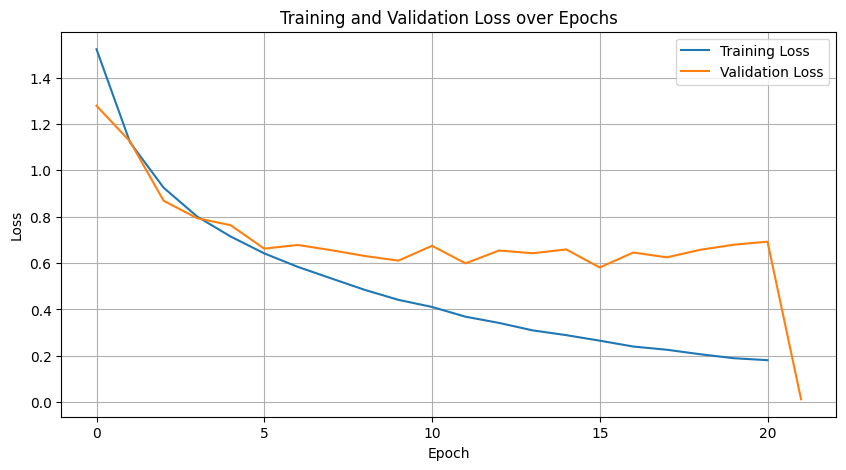

In [ ]:
def plot_losses(train_loss_per_epoch, val_loss_per_epoch):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_per_epoch, label="Training Loss")
    plt.plot(val_loss_per_epoch, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_losses(train_loss_per_epoch, val_loss_per_epoch)


# **ResNet-18 with Regularization**

The model is built on the standard ResNet-18 architecture and was trained on grayscale CIFAR-10 images, resized to 64×64 pixels.

To improve generalization and reduce overfitting, the model was modified to include dropout regularization in the final fully connected layer, with a dropout rate of 0.5. This randomly deactivates neurons during training, encouraging the network to learn more robust features.

In addition, the training pipeline included several data augmentation techniques to further enhance generalization such as Random horizontal flipping,
Random rotation, Color jitter (adjusting brightness, contrast, saturation, and hue)

Aside from these regularization enhancements, the core ResNet-18 structure remained unchanged, including its four residual blocks with skip connections and global average pooling before the final classification layer.


# **Training Summary**

The model was trained on the grayscale CIFAR-10 dataset, with input images resized to 64×64 pixels. The training process used the Adam optimizer, along with early stopping and checkpointing to monitor validation loss and save the best-performing model. Both training and validation losses were tracked per batch and averaged across each epoch. The application of dropout and data augmentation contributed to a smoother loss curve and improved generalization. Final evaluation was conducted on the CIFAR-10 test set using the best checkpoint saved during training.

Training Loss: 0.1813

Validation Loss: 0.0130

Final Test Accuracy: 0.8206

# **Transfer Learning**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import matplotlib.pyplot as plt
import os


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


class ResNetLightning(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.model = torchvision.models.resnet18()
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

In [ ]:

early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")


checkpoint_finetune = ModelCheckpoint(
    monitor="val_loss", mode="min",
    save_top_k=1, filename="resnet18-finetune-cifar10"
)
checkpoint_scratch = ModelCheckpoint(
    monitor="val_loss", mode="min",
    save_top_k=1, filename="resnet18-scratch-cifar10"
)

In [ ]:
# Model that was trained on the Imagenette dataset and fine-tuned it using the CIFAR10 dataset

checkpoint_path = "/content/imagenette_resnet.ckpt"
checkpoint = torch.load(checkpoint_path, map_location="cpu")


new_state_dict = {}
for k, v in checkpoint['state_dict'].items():

    if k.startswith("model.fc.1"):
        new_key = k.replace("model.fc.1", "model.fc")
        new_state_dict[new_key] = v
    else:
        new_state_dict[k] = v


model_finetune = ResNetLightning(num_classes=10)
model_finetune.load_state_dict(new_state_dict, strict=False)
logger_finetune = CSVLogger("logs/", name="finetune-cifar10", version="0")

trainer_finetune = Trainer(
    max_epochs=20,
    callbacks=[early_stop, checkpoint_finetune],
    logger=logger_finetune,
    accelerator="auto"
)

print("Starting fine-tuning experiment...")
trainer_finetune.fit(model_finetune, train_loader, val_loader)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 11.2 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Starting fine-tuning experiment...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
#Model Re-Trained from Scratch
model_scratch = ResNetLightning(num_classes=10)

logger_scratch = CSVLogger("logs/", name="scratch-cifar10", version="0")
early_stop = EarlyStopping(monitor="val_loss", patience=7, mode="min")
trainer_scratch = Trainer(
    max_epochs=20,
    callbacks=[early_stop, checkpoint_scratch],
    logger=logger_scratch,
    accelerator="auto"
)

print("Starting training from scratch experiment...")
trainer_scratch.fit(model_scratch, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 11.2 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Starting training from scratch experiment...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

CSV columns: Index(['epoch', 'step', 'train_acc_epoch', 'train_acc_step',
       'train_loss_epoch', 'train_loss_step', 'val_acc', 'val_loss'],
      dtype='object')


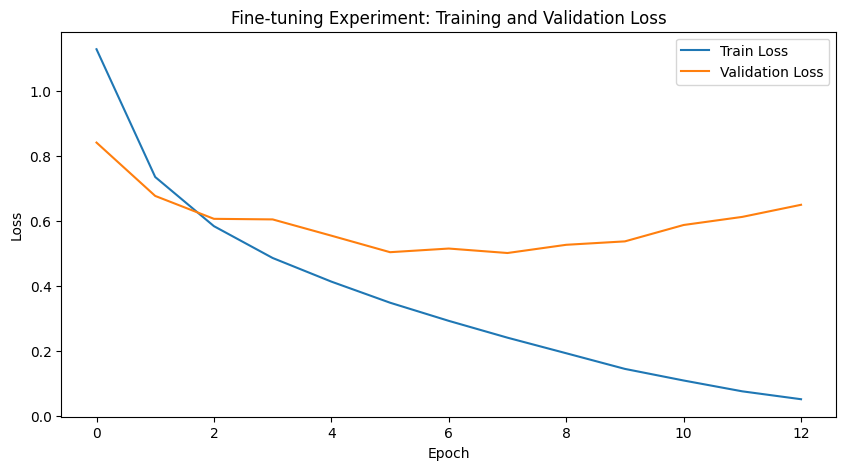

CSV columns: Index(['epoch', 'step', 'train_acc_epoch', 'train_acc_step',
       'train_loss_epoch', 'train_loss_step', 'val_acc', 'val_loss'],
      dtype='object')


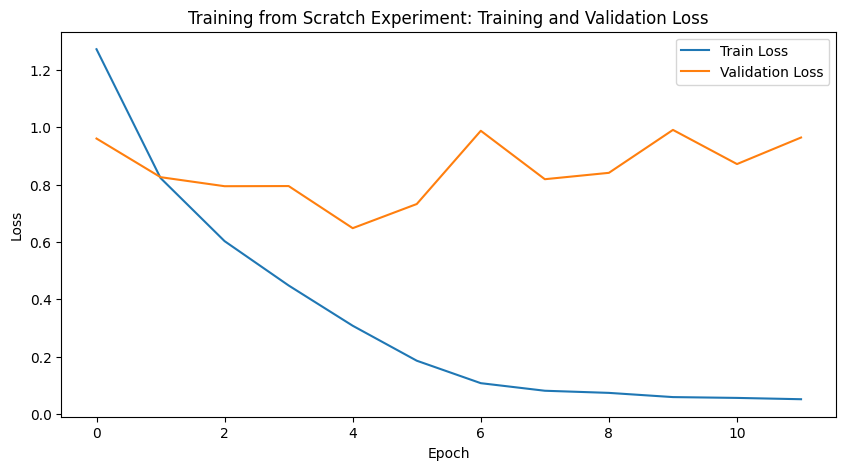

Training and plotting completed for both experiments.


In [ ]:
def plot_loss(log_file, title):

    df = pd.read_csv(log_file)
    print("CSV columns:", df.columns)


    if 'epoch' in df.columns:
        df_epoch = df.groupby("epoch").mean().reset_index()
    else:
        df_epoch = df


    if "train_loss" in df_epoch.columns:
        train_loss_col = "train_loss"
    elif "train_loss_epoch" in df_epoch.columns:
        train_loss_col = "train_loss_epoch"
    else:
        raise KeyError("Could not find train loss column in the CSV log.")


    if "val_loss" in df_epoch.columns:
        val_loss_col = "val_loss"
    elif "val_loss_epoch" in df_epoch.columns:
        val_loss_col = "val_loss_epoch"
    else:
        raise KeyError("Could not find validation loss column in the CSV log.")

    plt.figure(figsize=(10, 5))
    plt.plot(df_epoch["epoch"], df_epoch[train_loss_col], label="Train Loss")
    plt.plot(df_epoch["epoch"], df_epoch[val_loss_col], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()


finetune_log_file = os.path.join(logger_finetune.log_dir, "metrics.csv")
scratch_log_file = os.path.join(logger_scratch.log_dir, "metrics.csv")


plot_loss(finetune_log_file, "Fine-tuning Experiment: Training and Validation Loss")


plot_loss(scratch_log_file, "Training from Scratch Experiment: Training and Validation Loss")

print("Training and plotting completed for both experiments.")

# **Transfer Learning Summary**

## Fine-Tuned Model VS Trained from Scratch using Resnet18 Model

I used a ResNet18 model to explore transfer learning by comparing two training strategies on the CIFAR-10 dataset: training from scratch and fine-tuning a model pre-trained on the Imagenette dataset. The model’s architecture was modified to accept grayscale inputs and output 10 classes. Both models were trained under identical settings using PyTorch Lightning, with early stopping and validation monitoring enabled.

The fine-tuned model showed faster convergence and lower validation loss compared to the model trained from scratch. This indicates that transfer learning effectively leveraged the features learned from the Imagenette dataset, resulting in better performance and generalization on the CIFAR-10 task.

###  Model Comparison Table

| Metric                  | Fine-Tuned Model | Trained from Scratch |
|------------------------|------------------|-----------------------|
| Final Epoch            | 12               | 11                    |
| Train Accuracy (epoch) | 0.988            | 0.983                 |
| Validation Accuracy    | 0.834            | 0.786                 |
| Train Loss (epoch)     | 0.0508           | 0.0521                |
| Validation Loss        | 0.650            | 0.964                 |

